<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/dz_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Импорт библиотек**



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Настройка визуализаций
%matplotlib inline
sns.set(style="whitegrid")

### **Чтение данных**

In [ ]:
# Загружаем обучающую и тестовую выборки
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

# Проверяем размерность датасетов
print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

# Первые строки тренировочного датасета
train.head()

Train dataset shape: (4548, 28)
Test dataset shape: (1516, 27)


,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,...,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",...,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",...,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",...,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",...,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",...,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667


### **Предобработка данных**

In [ ]:
# Объединяем для общей предобработки
test['mean_price'] = np.nan
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test], ignore_index=True)

# Удалим аномалии: заменим цену < 3 руб на среднюю среди нормальных
mean_valid_price = df.loc[df['mean_price'] >= 3, 'mean_price'].mean()
df['mean_price'] = df['mean_price'].apply(lambda x: mean_valid_price if pd.notnull(x) and x < 3 else x)

# Опыт: извлекаем цифры и заменяем пропуски на медиану
def parse_experience(val):
    if pd.isnull(val): return np.nan
    digits = ''.join(c for c in str(val) if c.isdigit())
    return int(digits) if digits else np.nan

df['experience'] = df['experience'].apply(parse_experience)
df['experience'] = df['experience'].fillna(df['experience'].median())

# Заполняем пропуски
text_columns = ['description', 'experience_desc', 'Desc_Education_1', 'Desc_Education_2',
                'Desc_Education_3', 'Desc_Education_4', 'Desc_Education_5', 'Desc_Education_6']

for col in text_columns:
    df[col] = df[col].fillna('')

# Добавляем длину текстовых полей как признаки
df['experience_desc_len'] = df['experience_desc'].apply(lambda x: len(str(x)))
df['description_len'] = df['description'].apply(lambda x: len(str(x)))

# Образование — количество заполненных
education_cols = [f'Education_{i}' for i in range(1, 7)]
df['num_educations'] = df[education_cols].notna().sum(axis=1)

# TF-IDF для текстовых признаков
tfidf_features = {}
for col in text_columns:
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(df[col]).toarray()
    tfidf_features[col] = pd.DataFrame(tfidf_matrix, columns=[f"{col}_tfidf_{i}" for i in range(tfidf_matrix.shape[1])])

df_encoded = df.copy()
for col in text_columns:
    df_encoded = pd.concat([df_encoded.reset_index(drop=True), tfidf_features[col].reset_index(drop=True)], axis=1)

df_encoded.drop(columns=text_columns, inplace=True)

# Категориальные признаки
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].fillna('unknown')
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

### **Визуализация распределения стоимости 1 минуты на количество репетиторов**

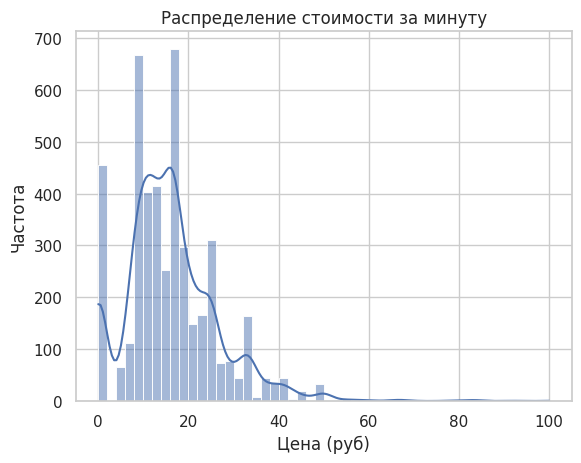

In [ ]:
# Распределение целевой переменной
sns.histplot(train['mean_price'], bins=50, kde=True)
plt.title("Распределение стоимости за минуту")
plt.xlabel("Цена (руб)")
plt.ylabel("Частота")
plt.show()

### **Тепловой график коррелляции**

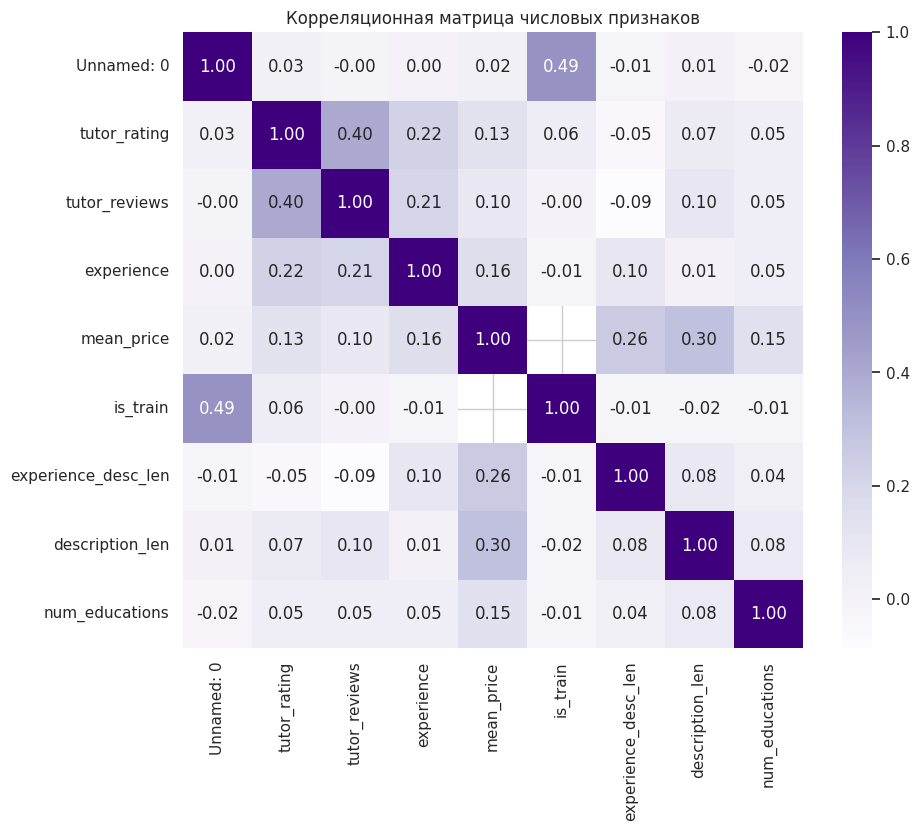

mean_price             1.000000
description_len        0.301397
experience_desc_len    0.257414
experience             0.155460
num_educations         0.145837
tutor_rating           0.130642
tutor_reviews          0.095510
Unnamed: 0             0.019080
is_train                    NaN
Name: mean_price, dtype: float64


In [ ]:
# Выбираем только числовые признаки + целевую переменную
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Строим корреляционную матрицу
corr_matrix = df[num_cols].corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt=".2f")
plt.title("Корреляционная матрица числовых признаков")
plt.show()

# Расчёт и сортировка корреляций с целевой переменной
correlation_with_target = df.corr(numeric_only=True)['mean_price'].sort_values(ascending=False)
print(correlation_with_target)

**Вывод по корреляции:**
* description_len - чем подробнее описание, тем выша цена
* experience_desc_len - аналогично, чем длинне описание опыта, тем дороже
* experience - стаж работы также влияет на стоимость, влияние умеренное
* num_educations - больше образований - выше цена, но эффект небольшой
* tutor_rating - рейтинг также входит в топ метрик, влияющих на стоимость, небольшое влияние

Сильных корреляций (>0,5) нет, но несколько слабых и логичных — это уже хорошо.


### **Деление даннных на выборки**

In [ ]:
# Делим обратно
train_encoded = df_encoded[df_encoded['is_train'] == 1].drop(columns=['is_train'])
test_encoded = df_encoded[df_encoded['is_train'] == 0].drop(columns=['is_train', 'mean_price'])

X = train_encoded.drop('mean_price', axis=1)
y = train_encoded['mean_price']

# Делим на train и validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Заполняем пропуски
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_val.median())

### **Обучение моделей**

Далее можем обучить разные модели, оценить точность предсказаний каждой из моделей:
* Decision Tree
* Random Forest
* KNN
* XGBoost



In [ ]:
# Обучение моделей
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    print(f"\nМодель - {name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")


Модель - Decision Tree
MAE: 6.17
RMSE: 9.94
R²: -0.0775

Модель - Random Forest
MAE: 4.86
RMSE: 7.98
R²: 0.3066

Модель - KNN
MAE: 6.48
RMSE: 9.54
R²: 0.0078

Модель - XGBoost
MAE: 5.13
RMSE: 8.27
R²: 0.2538


1.	**MAE (Mean Absolute Error)**: Эта метрика показывает среднее абсолютное отклонение предсказанных значений от истинных. Чем меньше MAE, тем лучше модель. В идеале MAE должен быть как можно ближе к нулю.
2.	**RMSE (Root Mean Squared Error)**: Это корень из среднего квадратичного отклонения. RMSE более чувствителен к большим ошибкам, чем MAE, и, как правило, дает большее значение. Как и MAE, меньшее значение RMSE свидетельствует о лучшей модели.
3.	**R² (R-squared)**: Эта метрика отражает, какую долю дисперсии целевой переменной удается объяснить моделью. R² может варьироваться от минус бесконечности до 1, где 1 означает идеальную модель, а отрицательные значения означают, что модель работает хуже, чем просто прогнозирование среднего значения.

**Лучшая модель: Random Forest** — у неё:

*	Самая низкая MAE и RMSE
*	Самое высокое R²

Это означает, что она предсказывает наиболее точно и стабильно по сравнению с другими. Далее подберем гиперпараметры именно для этой модели

### **Подбор гиперпараметров**

In [ ]:
# Подбор гиперпараметров для Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Финальные метрики
val_preds = best_model.predict(X_val)
print("\nЛучшая модель после GridSearch:")
print(grid_search.best_params_)
print(f"MAE: {mean_absolute_error(y_val, val_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, val_preds)):.2f}")
print(f"R²: {r2_score(y_val, val_preds):.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Лучшая модель после GridSearch:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 4.85
RMSE: 7.97
R²: 0.3079


### **Визуализация результатов**

Фактические значения vs Предсказанные

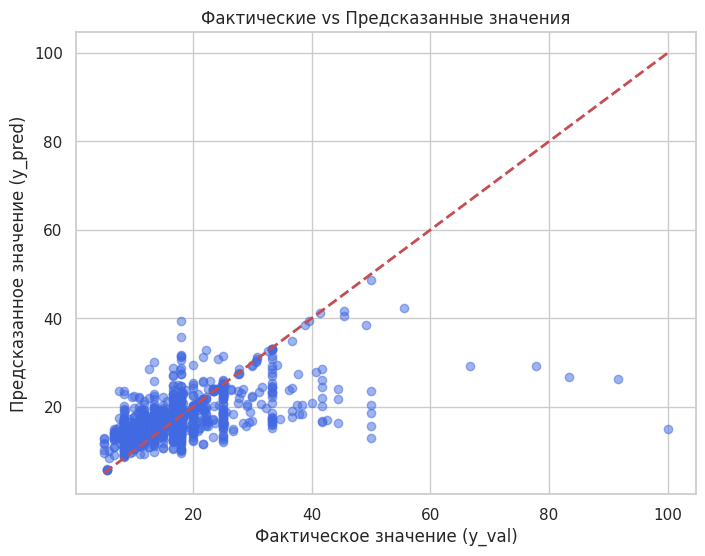

In [ ]:
# Предсказания модели
y_pred = best_model.predict(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Фактическое значение (y_val)')
plt.ylabel('Предсказанное значение (y_pred)')
plt.title('Фактические vs Предсказанные значения')
plt.grid(True)
plt.show()

Гистограмма ошибок

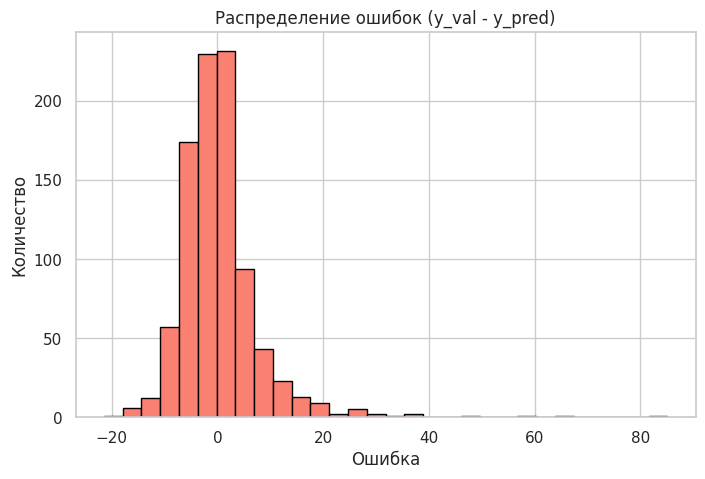

In [ ]:
errors = y_val - y_pred

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color='salmon', edgecolor='black')
plt.title('Распределение ошибок (y_val - y_pred)')
plt.xlabel('Ошибка')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

### **Выгрузка файла**

In [ ]:
# Предсказания и выгрузка
final_preds = best_model.predict(test_encoded)
submission = pd.DataFrame({
    'index': test.index,
    'mean_price': final_preds
})
submission.to_csv('sample_submit.csv', index=False)
print("\nФайл 'sample_submit.csv' сохранён. Строк:", submission.shape[0])



Файл 'sample_submit.csv' сохранён. Строк: 1516


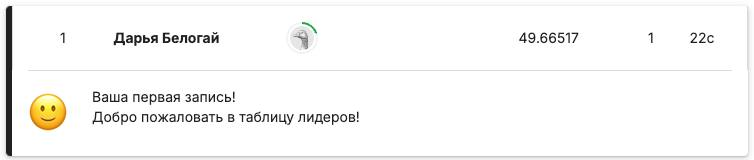